C:\Users\Urban\AppData\Local\Temp\ipykernel_3536\2294662513.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


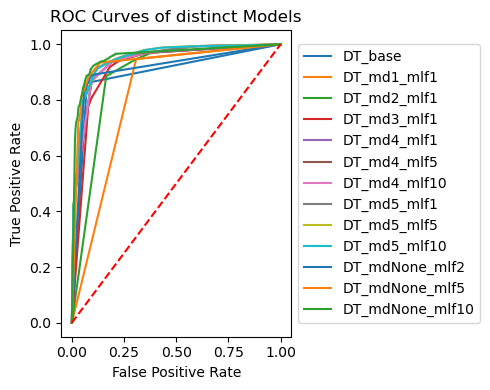


>>> Model: DT_base


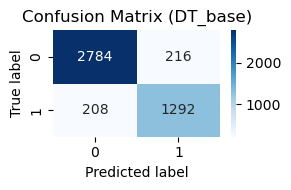


>>> Model: DT_md1_mlf1


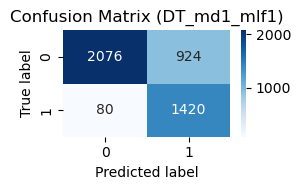


>>> Model: DT_md2_mlf1


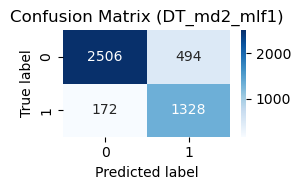


>>> Model: DT_md3_mlf1


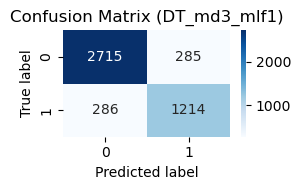


>>> Model: DT_md4_mlf1


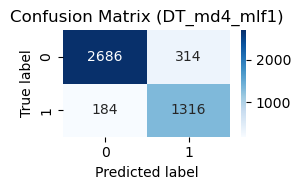


>>> Model: DT_md4_mlf5


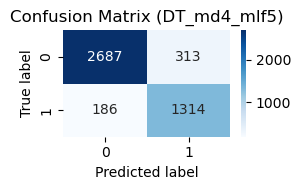


>>> Model: DT_md4_mlf10


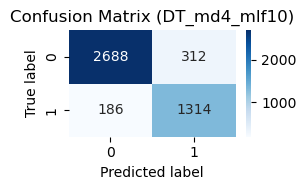


>>> Model: DT_md5_mlf1


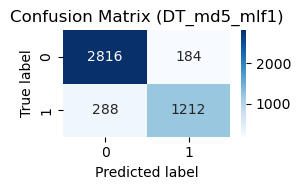


>>> Model: DT_md5_mlf5


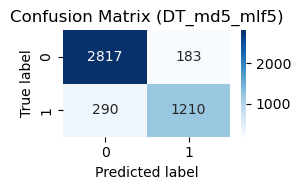


>>> Model: DT_md5_mlf10


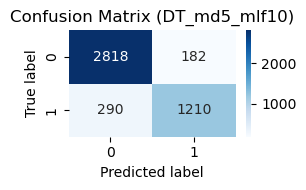


>>> Model: DT_mdNone_mlf2


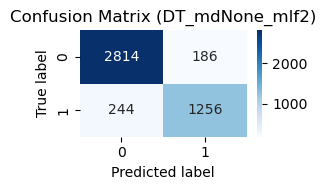


>>> Model: DT_mdNone_mlf5


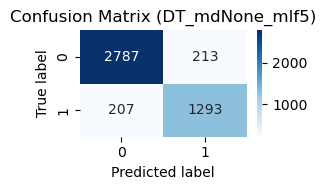


>>> Model: DT_mdNone_mlf10


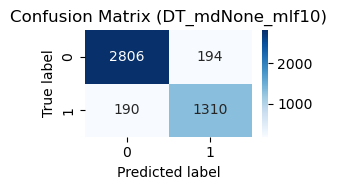


### Zestawienie metryk (bez duplikatów) ###



,Model,max_depth,min_samples_leaf,Accuracy,Precision,Recall,F1_score,AUC
0,DT_base,None,None,0.905778,0.893623,0.894667,0.894141,0.894667
1,DT_md1_mlf1,1,1,0.776889,0.784348,0.819333,0.772045,0.819333
2,DT_md2_mlf1,2,1,0.852000,0.832321,0.860333,0.841112,0.883815
3,DT_md3_mlf1,3,1,0.873111,0.857286,0.857167,0.857226,0.917607
4,DT_md4_mlf1,4,1,0.889333,0.871625,0.886333,0.878028,0.936084
5,DT_md4_mlf5,4,5,0.889111,0.871440,0.885833,0.877729,0.940099
6,DT_md4_mlf10,4,10,0.889333,0.871700,0.886000,0.877955,0.939898
7,DT_md5_mlf1,5,1,0.895111,0.887706,0.873333,0.879845,0.947711
8,DT_md5_mlf5,5,5,0.894889,0.887646,0.872833,0.879525,0.950175
9,DT_md5_mlf10,5,10,0.895111,0.887973,0.873000,0.879758,0.949595


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix, 
    roc_curve, 
    roc_auc_score
)
from sklearn.model_selection import train_test_split

# dtreeviz (nowsze API)
from dtreeviz import model as dtree_model

# --------------------
# 1. Wczytanie danych
# --------------------
diabetes = pd.read_csv('diabetes.csv')

features = [
    'Pregnancies','PlasmaGlucose','DiastolicBloodPressure',
    'TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age'
]
target = 'Diabetic'
X, y = diabetes[features], diabetes[target]

# Tym razem skorzystamy z więcej niż 2 cech (drzewa nie wymagają skalowania)
# Ale jeśli chcesz, możesz używać wciąż tylko 2 cech w X 
# i ewentualnie standaryzować – to nie zaszkodzi, choć nie jest konieczne.
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.30, 
    random_state=0, 
    stratify=y
)

# -------------------
# 2. (Opcjonalnie) Standaryzacja
# -------------------
# Drzewa decyzyjne nie potrzebują skalowania. Jeśli chcesz je jednak zachować:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# -------------------
# 3. Struktury danych
# -------------------
metrics_dataframe = pd.DataFrame(
    columns=[
        'Model', 'max_depth', 'min_samples_leaf', 
        'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC'
    ]
)

stored_models = []
existing_metrics_set = set()  # Zbiór krotek z metrykami, by wykluczać duplikaty

# -----------------------------------------
# 4. Funkcja do obliczania metryk
# -----------------------------------------
def get_metrics(model, X_checked, y_checked):
    y_pred = model.predict(X_checked)
    # W przypadku drzew decyzyjnych predict_proba zwraca P(y=0) i P(y=1) 
    # – bierzemy więc drugą kolumnę jako prawdopodobieństwo klasy 1 (Diabetic).
    y_proba = model.predict_proba(X_checked)[:, 1]
    
    report = classification_report(y_checked, y_pred, output_dict=True)
    accuracy = report['accuracy']
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1_metric = report['macro avg']['f1-score']
    auc_metric = roc_auc_score(y_checked, y_proba)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1_metric,
        'auc': auc_metric,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

# --------------------------
# 5. Funkcje do rysowania metryk
# --------------------------
def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix ({model_name})")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_curves(stored_models, X_test, y_test):
    plt.figure(figsize=(5, 4))
    for (model, name, _, y_proba) in stored_models:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=name)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title("ROC Curves of distinct Models")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# ----------------------------------
# 6. Funkcja "train_and_store"
# ----------------------------------
def train_and_store(
    max_depth,
    min_samples_leaf,
    X_train_data,
    y_train_data,
    X_test_data,
    y_test_data
):
    global metrics_dataframe, stored_models, existing_metrics_set
    
    model_tree = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=0
    )
    model_tree.fit(X_train_data, y_train_data)
    
    # 1) Obliczamy metryki
    metrics = get_metrics(model_tree, X_test_data, y_test_data)
    
    # 2) Przygotowujemy krotkę z wartościami metryk (zaokrąglamy)
    metrics_tuple = (
        round(metrics['accuracy'], 4),
        round(metrics['precision'], 4),
        round(metrics['recall'], 4),
        round(metrics['f1'], 4),
        round(metrics['auc'], 4)
    )
    
    # Jeżeli taki zestaw metryk już istnieje -> pomijamy
    if metrics_tuple in existing_metrics_set:
        return
    
    existing_metrics_set.add(metrics_tuple)
    
    model_name = f"DT_md{max_depth}_mlf{min_samples_leaf}"
    
    # 3) Dodajemy wiersz do DataFrame
    new_row = {
        'Model': model_name,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1_score': metrics['f1'],
        'AUC': metrics['auc'],
    }
    
    metrics_dataframe = pd.concat([
        metrics_dataframe,
        pd.DataFrame([new_row])
    ], ignore_index=True)
    
    # Możesz ewentualnie skasować puste kolumny, by uniknąć ostrzeżeń:
    # metrics_dataframe.dropna(axis=1, how='all', inplace=True)
    
    stored_models.append(
        (model_tree, model_name, metrics['y_pred'], metrics['y_proba'])
    )

# ----------------------------
# 7. Model bazowy
# ----------------------------
# Jako model bazowy wybierz np. "płytkie" drzewo bez ograniczeń (poza random_state)
base_tree = DecisionTreeClassifier(random_state=0)
base_tree.fit(X_train, y_train)

base_metrics = get_metrics(base_tree, X_test, y_test)
base_model_name = "DT_base"

base_metrics_tuple = (
    round(base_metrics['accuracy'], 4),
    round(base_metrics['precision'], 4),
    round(base_metrics['recall'], 4),
    round(base_metrics['f1'], 4),
    round(base_metrics['auc'], 4)
)
existing_metrics_set.add(base_metrics_tuple)

metrics_dataframe = pd.concat([
    metrics_dataframe,
    pd.DataFrame([{
        'Model': base_model_name,
        'max_depth': None,
        'min_samples_leaf': None,
        'Accuracy': base_metrics['accuracy'],
        'Precision': base_metrics['precision'],
        'Recall': base_metrics['recall'],
        'F1_score': base_metrics['f1'],
        'AUC': base_metrics['auc'],
    }])
], ignore_index=True)

stored_models.append(
    (base_tree, base_model_name, base_metrics['y_pred'], base_metrics['y_proba'])
)

# --------------------------------------------
# 8. Tworzenie kolejnych modeli w pętli
# --------------------------------------------
max_depth_list = [1, 2, 3, 4, 5, None]  # None = bez ograniczeń
min_samples_leaf_list = [1, 2, 5, 10]

for depth in max_depth_list:
    for leaf_size in min_samples_leaf_list:
        # Pomijamy parę (None, 1) jeśli jest dokładnie identyczna jak nasz model bazowy
        # z random_state=0 i brakiem ograniczeń
        # Ale tu raczej zawsze trenujemy, bo i tak mogą dać inny wynik
        train_and_store(
            depth,
            leaf_size,
            X_train,
            y_train,
            X_test,
            y_test
        )

# ------------------------------------------
# 9. Wyświetlenie wybranych wyników
# ------------------------------------------

# Zbiorczy wykres ROC dla modeli
plot_roc_curves(stored_models, X_test, y_test)

# Rysujemy macierz pomyłek i (opcjonalnie) jakąś wizualizację drzewa
for (model_tree, model_name, y_pred, y_proba) in stored_models:
    print(f"\n>>> Model: {model_name}")
    plot_confusion_matrix(model_name, y_test, y_pred)
    
    # Wizualizacja drzewa przy użyciu dtreeviz
    # (możesz tu np. tworzyć w pętli pliki PNG/PDF
    #  lub dynamicznie wyświetlać w notatniku)
    viz_model = dtree_model(
        model_tree,
        X_train,  # to te dane, na których trenujesz
        y_train,
        feature_names=list(X.columns),
        target_name="Diabetic",
        class_names=["Not Diabetic", "Diabetic"]
    )
    # Jeżeli pracujesz w środowisku notebookowym, to .view() wyświetli interaktywnie:
    # viz_model.view()
    # Ewentualnie zapis:
    # viz_model.save("example_tree.svg")

print("\n### Zestawienie metryk (bez duplikatów) ###\n")
metrics_dataframe